In [2]:
import torch
import numpy as np
import cv2

In [3]:
# downloading the semantic segmentation model
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Using cache found in /home/sidroy/.cache/torch/hub/pytorch_vision_v0.5.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [46]:
import urllib
"""
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
"""
filename = '/home/sidroy/Downloads/car6.png'

In [47]:
img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
scale_percent = 100 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
print("Dimensions of input to segmentation code {}".format(dim))
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('segmentation_image.png', img)
filename = 'segmentation_image.png'

Dimensions of input to segmentation code (640, 331)


In [48]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
# Input image is opened in this line
input_image = Image.open(filename)
print("Shape of Input Image {}".format(input_image.size))
dim_input_image = len(input_image.size)
"""
if dim_input_image == 2:
    input_image = input_image.resize(1,input_image.size[0],input_image.size[1])
"""

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# preprocessed image after all the transformations
input_tensor = preprocess(input_image)
print("Input Tensor Size is {}".format(input_tensor.shape))
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    # output is the pytorch tensor output by the segmentation model
    # it contains the probability of each pixel being ina certain class
    output = model(input_batch)['out'][0]
# output predictions is array of pixels with max probability of being in a class
output_predictions = output.argmax(0)
print('output shape is {}'.format(output.shape))
print('output_predictions is of shape {}'.format(output_predictions.shape))

Shape of Input Image (640, 331)


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

<IPython.core.display.Javascript object>


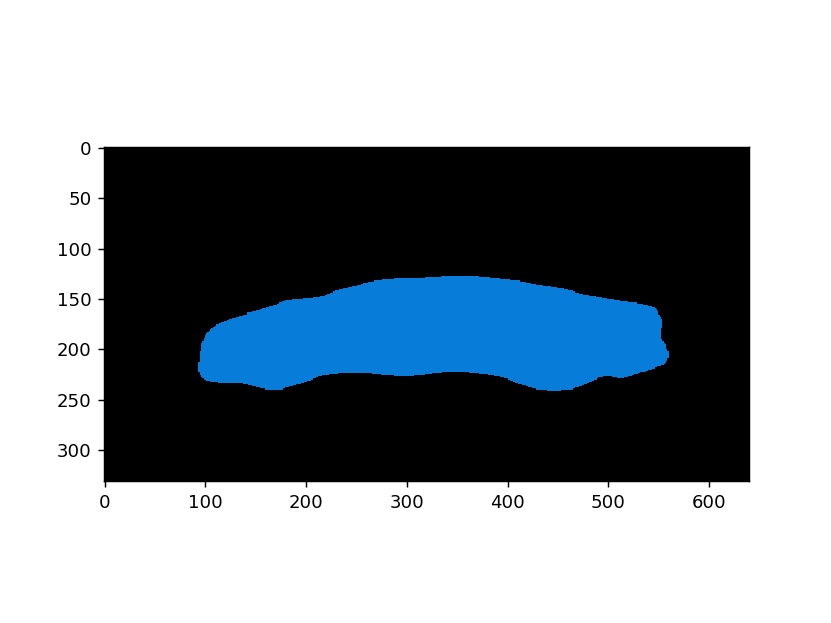

In [43]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
%matplotlib notebook
plt.imshow(r)
plt.show()

<IPython.core.display.Javascript object>


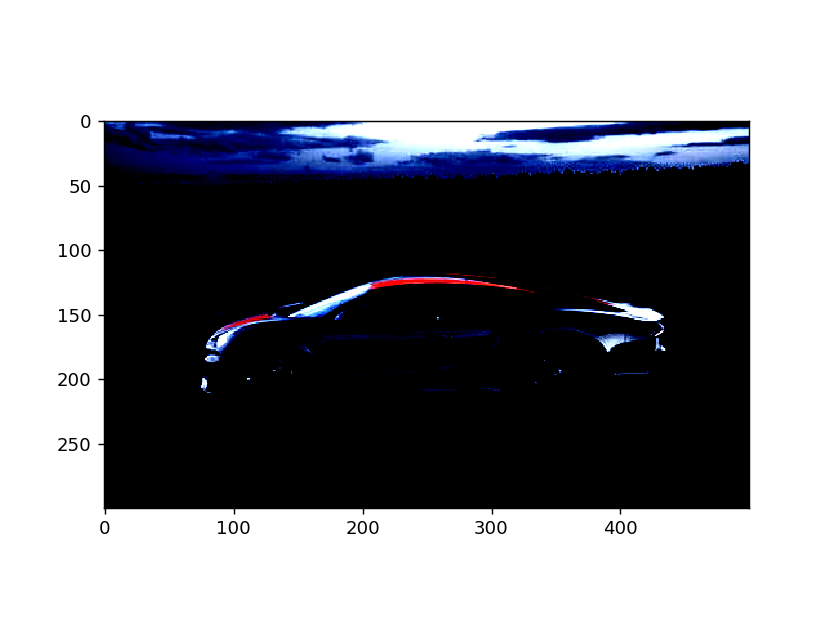

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [36]:
%matplotlib notebook
plt.imshow(  input_tensor.permute(1, 2, 0)  )

<IPython.core.display.Javascript object>


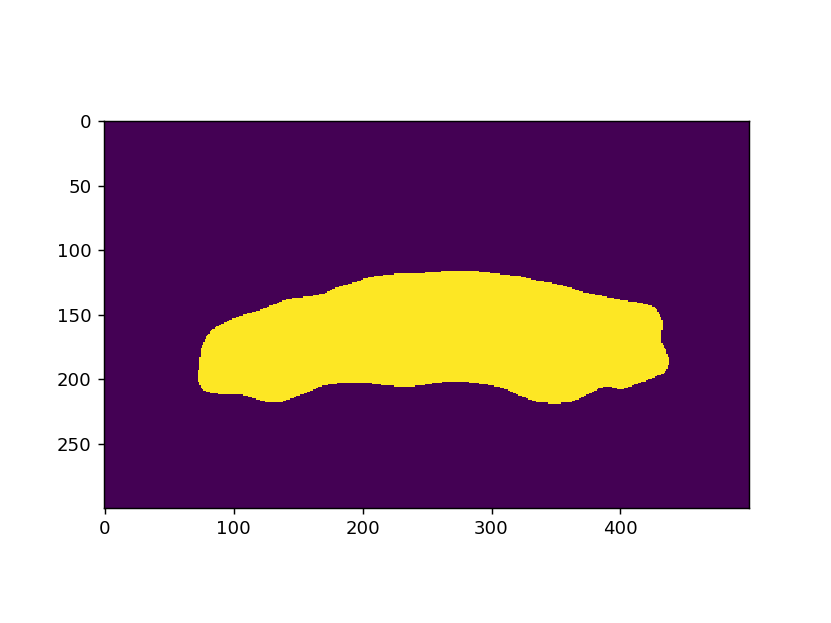

In [37]:
%matplotlib notebook
mask = output_predictions.cpu()
plt.imshow( mask )

In [38]:
import cv2
res = np.array(input_image)
res[60, 60]
b_channel, g_channel, r_channel = cv2.split(res)
print(b_channel.shape)
print(g_channel.shape)
print(r_channel.shape)

mask_array = np.asarray(mask)
mask_array = np.where(mask!=7, 0, 255)
mask_array = mask_array.astype(np.uint8)
print( type(mask_array) ) 
print( type(b_channel)  )

alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 50
img_BGRA = cv2.merge((b_channel, g_channel, r_channel, mask_array))
img_RGBA = cv2.merge(( r_channel, g_channel, b_channel, mask_array))

image_width = img_RGBA.shape[1]
image_height = img_RGBA.shape[0]
scale_percent = 137/image_width*100
print(scale_percent)
width = int(img_RGBA.shape[1] * scale_percent / 100)
height = int(img_RGBA.shape[0] * scale_percent / 100)
dim = (width, height)
resized_RGBA = cv2.resize(img_RGBA, dim, interpolation = cv2.INTER_AREA)

(300, 500)
(300, 500)
(300, 500)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
27.400000000000002


<IPython.core.display.Javascript object>


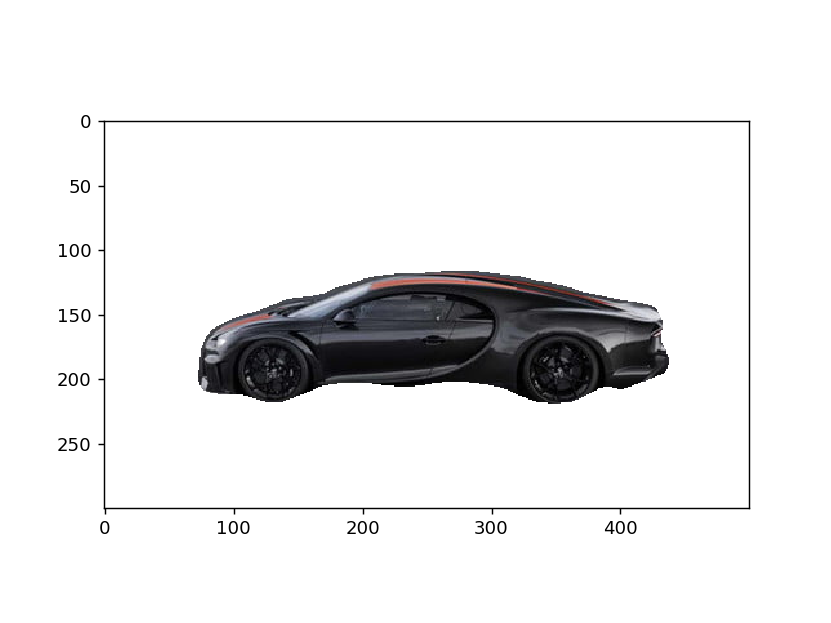

True

In [39]:
%matplotlib notebook
plt.imshow(img_BGRA)
plt.show()
cv2.imwrite('/home/sidroy/Insight/projects/Pix2Vox/LargeDatasets/DemoImage/car/car_subfolder/rendering/03.png', resized_RGBA) 

In [21]:
import glob
import os

file_list = glob.glob(os.path.join(os.getcwd(), "load_images", "*.*"))

print(file_list)

i = 0
for file_path in file_list:
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    img_name = '{:02d}'.format(i)
    cv2.imwrite(img_name+'.png',img)
    i+=1
    

['/home/sidroy/Insight/projects/Pix2Vox/load_images/ghsthferw.png', '/home/sidroy/Insight/projects/Pix2Vox/load_images/gfhfghfgh.png', '/home/sidroy/Insight/projects/Pix2Vox/load_images/fgdfgdg.png', '/home/sidroy/Insight/projects/Pix2Vox/load_images/sadsdasd.png', '/home/sidroy/Insight/projects/Pix2Vox/load_images/yhetrhert.png']
[]


In [26]:
folder_name = "load_images"
file_list = glob.glob(os.path.join(os.getcwd(), folder_name, "*.*"))

In [27]:
print(file_list)

['/home/sidroy/Insight/projects/Pix2Vox/load_images/ghsthferw.png', '/home/sidroy/Insight/projects/Pix2Vox/load_images/gfhfghfgh.png', '/home/sidroy/Insight/projects/Pix2Vox/load_images/fgdfgdg.png', '/home/sidroy/Insight/projects/Pix2Vox/load_images/sadsdasd.png', '/home/sidroy/Insight/projects/Pix2Vox/load_images/yhetrhert.png']
